In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import os

In [51]:
sns.set_style("ticks")
sns.set_context("paper",font_scale=2.0)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

import matplotlib
import matplotlib.pyplot as plt
font = {'family': 'serif', 'serif': ['Gentium Basic'], 'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Gentium Basic'
matplotlib.rcParams['mathtext.it'] = 'Gentium Basic:italic'
matplotlib.rcParams['mathtext.bf'] = 'Gentium Basic:bold'

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

pgf_with_custom_preamble = {
"font.family": "serif", # use serif/main font for text elements
"text.usetex": False,    # use inline math for ticks
"pgf.preamble": [
    "\\usepackage{mathpazo}",
    "\\usepackage{gentium}",
    "\\DeclareSymbolFont{sfnumbers}{T1}{gentium}{m}{n}",
    "\\SetSymbolFont{sfnumbers}{bold}{T1}{gentium}{bx}{n}",
    "\\DeclareMathSymbol{0}\mathalpha{sfnumbers}{\"30}",
    "\\DeclareMathSymbol{1}\mathalpha{sfnumbers}{\"31}",
    "\\DeclareMathSymbol{2}\mathalpha{sfnumbers}{\"32}",
    "\\DeclareMathSymbol{3}\mathalpha{sfnumbers}{\"33}",
    "\\DeclareMathSymbol{4}\mathalpha{sfnumbers}{\"34}",
    "\\DeclareMathSymbol{5}\mathalpha{sfnumbers}{\"35}",
    "\\DeclareMathSymbol{6}\mathalpha{sfnumbers}{\"36}",
    "\\DeclareMathSymbol{7}\mathalpha{sfnumbers}{\"37}",
    "\\DeclareMathSymbol{8}\mathalpha{sfnumbers}{\"38}",
    "\\DeclareMathSymbol{9}\mathalpha{sfnumbers}{\"39}",
    "\\DeclareMathSymbol{,}\mathalpha{sfnumbers}{\"2C}"
    ]
}
matplotlib.rcParams.update(pgf_with_custom_preamble)

/home/sbg/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [140]:
from collections.abc import Iterable
from sklearn import linear_model

class AxTransformer:
    def __init__(self, datetime_vals=False):
        self.datetime_vals = datetime_vals
        self.lr = linear_model.LinearRegression()
        
        return
    
    def process_tick_vals(self, tick_vals):
        if not isinstance(tick_vals, Iterable) or isinstance(tick_vals, str):
            tick_vals = [tick_vals]
            
        if self.datetime_vals == True:
            tick_vals = pd.to_datetime(tick_vals).astype(int).values
            
        tick_vals = np.array(tick_vals)
            
        return tick_vals
    
    def fit(self, ax, axis='x'):
        axis = getattr(ax, f'get_{axis}axis')()
        
        tick_locs = axis.get_ticklocs()
        tick_vals = self.process_tick_vals([label._text for label in axis.get_ticklabels()])
        
        self.lr.fit(tick_vals.reshape(-1, 1), tick_locs)
        
        return
    
    def transform(self, tick_vals):        
        tick_vals = self.process_tick_vals(tick_vals)
        tick_locs = self.lr.predict(np.array(tick_vals).reshape(-1, 1))
        
        return tick_locs
    
def set_date_ticks(ax, start_date, end_date, axis='y', date_format='%Y-%m-%d', **date_range_kwargs):
    dt_rng = pd.date_range(start_date, end_date, **date_range_kwargs)

    ax_transformer = AxTransformer(datetime_vals=True)
    ax_transformer.fit(ax, axis=axis)
    
    getattr(ax, f'set_{axis}ticks')(ax_transformer.transform(dt_rng))
    getattr(ax, f'set_{axis}ticklabels')(dt_rng.strftime(date_format))

    ax.tick_params(axis=axis, which='both', bottom=True, top=False, labelbottom=True)
    
    return ax

In [9]:
dir = '../data/'
trackrecovery_dir = dir + 'US_States/TrackTheRecovery/'
print(os.listdir(trackrecovery_dir))
tr_data = [pd.read_csv(trackrecovery_dir + f) for f in os.listdir(trackrecovery_dir)]
print([tr_data[i] for i in range(len(tr_data))])

['Affinity - State - Daily.csv', 'Burning Glass - State - Weekly.csv', 'COVID - State - Daily.csv', 'Employment Combined - State - Daily.csv', 'GeoIDs - State.csv', 'Google Mobility - State - Daily.csv', 'Womply - State - Daily.csv', 'Zearn - State - Weekly.csv']
[       year  month  day  statefips freq spend_acf spend_aer spend_all  \
0      2020      1    1          1    d         .         .         .   
1      2020      1    1          2    d         .         .         .   
2      2020      1    1          4    d         .         .         .   
3      2020      1    1          5    d         .         .         .   
4      2020      1    1          6    d         .         .         .   
...     ...    ...  ...        ...  ...       ...       ...       ...   
20304  2021      2   14         51    w     -.287     -.549    -.0235   
20305  2021      2   14         53    w     -.426     -.618    -.0061   
20306  2021      2   14         54    w     -.204     -.411      .115   
20307

In [10]:
for sub_dat in tr_data:
  if 'day_endofweek' in sub_dat.columns:
    sub_dat.loc[:,'day'] = sub_dat['day_endofweek']
  if 'year' in sub_dat.columns:
    sub_dat.loc[:,'Date'] = pd.to_datetime(sub_dat['year'].astype(str) + '/' + sub_dat['month'].astype('str') + '/' + sub_dat['day'].astype(str))

master_dat = tr_data[0]
for i in range(1,len(tr_data)):
  if 'Date' in tr_data[i].columns:
    master_dat = master_dat.merge(right=tr_data[i], on=['statefips', 'Date', 'year', 'month', 'day'], how='outer')

geo_xwalk = pd.read_csv(trackrecovery_dir + 'GeoIDs - State.csv')
geo_xwalk = geo_xwalk[['statefips', 'statename', 'stateabbrev']]
master_dat = master_dat.merge(geo_xwalk, how='left', indicator='xwalk')
print(master_dat['xwalk'].value_counts())
print(master_dat.columns)
print(master_dat['statefips'].value_counts().sort_index())

both          24115
right_only        0
left_only         0
Name: xwalk, dtype: int64
Index(['year', 'month', 'day', 'statefips', 'freq', 'spend_acf', 'spend_aer',
       'spend_all', 'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws',
       'spend_all_inchigh', 'spend_all_inclow', 'spend_all_incmiddle',
       'spend_retail_w_grocery', 'spend_retail_no_grocery', 'provisional',
       'Date', 'day_endofweek_x', 'bg_posts', 'bg_posts_ss30', 'bg_posts_ss55',
       'bg_posts_ss60', 'bg_posts_ss65', 'bg_posts_ss70', 'bg_posts_jz1',
       'bg_posts_jzgrp12', 'bg_posts_jz2', 'bg_posts_jz3', 'bg_posts_jzgrp345',
       'bg_posts_jz4', 'bg_posts_jz5', 'case_count', 'death_count',
       'test_count', 'case_rate', 'death_rate', 'test_rate', 'new_case_rate',
       'new_death_rate', 'new_test_rate', 'new_case_count', 'new_death_count',
       'new_test_count', 'emp_combined', 'emp_combined_inclow',
       'emp_combined_incmiddle', 'emp_combined_inchigh', 'emp_combined_ss40',
       'emp_combi

<ipython-input-11-dbafd437a048>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  master_dat['Date'].describe()


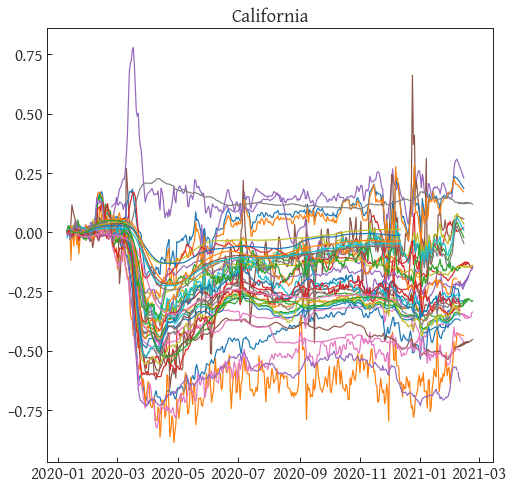

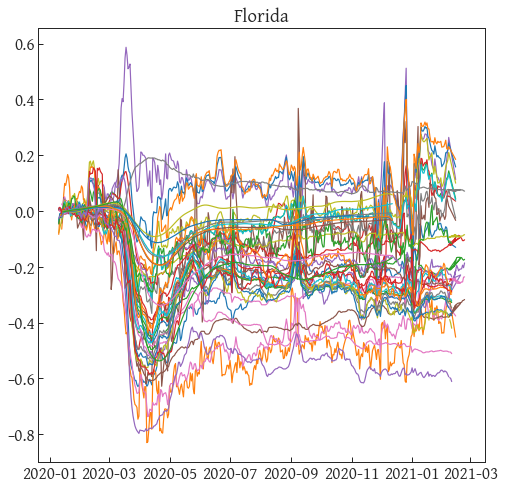

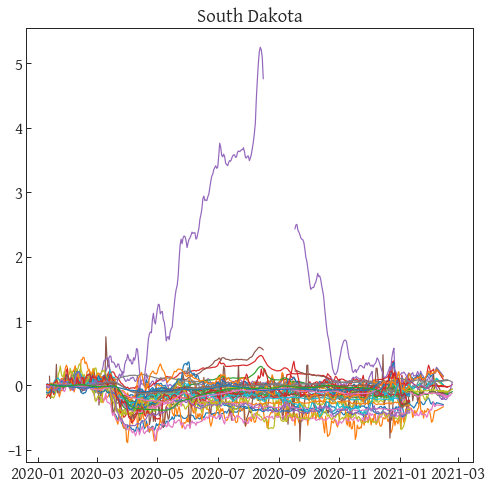

In [11]:
master_dat['Date'].describe()
fields_to_plot = ['spend_acf', 'spend_aer', 'spend_all', 
                  'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws', 'spend_all_inchigh', 
                  'spend_all_inclow', 'spend_all_incmiddle', 'spend_retail_w_grocery',
                  'spend_retail_no_grocery', 'gps_retail_and_recreation',
                  'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
                  'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'merchants_all', 'merchants_inchigh',
                  'merchants_inclow', 'merchants_incmiddle', 'merchants_ss40',
                  'merchants_ss60', 'merchants_ss65', 'merchants_ss70', 'revenue_all',
                  'revenue_inchigh', 'revenue_inclow', 'revenue_incmiddle',
                  'revenue_ss40', 'revenue_ss60', 'revenue_ss65', 'revenue_ss70', 'emp_combined',
                  'emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh',
                  'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss65',
                  'emp_combined_ss70']
master_dat.loc[:,fields_to_plot] = master_dat.loc[:,fields_to_plot].replace('.', np.nan)
master_dat.loc[:,fields_to_plot] = master_dat.loc[:,fields_to_plot].astype(float)

master_dat.to_csv(dir + 'US_States/cleaned_data/track_recovery_clean.csv')

plt.figure(figsize=(8,8))
plt.plot(master_dat.loc[master_dat['statefips']==6,'Date'], master_dat.loc[master_dat['statefips']==6, fields_to_plot])
plt.title('California')
#plt.legend(fields_to_plot)

plt.figure(figsize=(8,8))
plt.plot(master_dat.loc[master_dat['statefips']==12,'Date'], master_dat.loc[master_dat['statefips']==12, fields_to_plot])
plt.title('Florida')

plt.figure(figsize=(8,8))
plt.plot(master_dat.loc[master_dat['statefips']==46,'Date'], master_dat.loc[master_dat['statefips']==46, fields_to_plot])
plt.title('South Dakota')
plt.show()

In [12]:
open_table = pd.read_csv(dir + 'US_States/YoY_Seated_Diner_Data.csv')
ot_us = open_table.loc[open_table['Type']=='state']

geo_xwalk = pd.read_csv(trackrecovery_dir + 'GeoIDs - State.csv')
geo_xwalk = geo_xwalk[['statefips', 'statename', 'stateabbrev']]
ot_us = ot_us.merge(geo_xwalk, left_on='Name', right_on='statename', how='left', indicator='match')
ot_us = ot_us.loc[ot_us['match'] == 'both']
ot_us = ot_us.set_index(['Type', 'Name', 'statename', 'stateabbrev', 'statefips', 'match'])
col_orig = list(ot_us.columns)
col_orig = [s.replace('.1', '') for s in col_orig]
columns_corrected = [col_orig[i]+'/20' if i <= col_orig.index('12/31') else col_orig[i]+'/21' for i in range(len(col_orig))]
ot_us.columns = columns_corrected

ot_us = pd.melt(ot_us, var_name='date_str', ignore_index=False).reset_index()
ot_us['Date'] = pd.to_datetime(ot_us['date_str'])
ot_us['open_table_seatings'] = ot_us['value'] / 100
print(ot_us['statename'].value_counts().sort_index())
ot_us = ot_us[['statefips', 'Date', 'open_table_seatings']]

ot_us.to_csv(dir + 'US_States/cleaned_data/open_table_clean.csv')


Alabama                 377
Arizona                 377
California              377
Colorado                377
Connecticut             377
Delaware                377
District of Columbia    377
Florida                 377
Georgia                 377
Hawaii                  377
Illinois                377
Indiana                 377
Kansas                  377
Kentucky                377
Louisiana               377
Maine                   377
Maryland                377
Massachusetts           377
Michigan                377
Minnesota               377
Missouri                377
Nebraska                377
Nevada                  377
New Hampshire           377
New Jersey              377
New Mexico              377
New York                377
North Carolina          377
Ohio                    377
Oklahoma                377
Oregon                  377
Pennsylvania            377
Rhode Island            377
South Carolina          377
Tennessee               377
Texas               

In [16]:
master_dat_ot['Date']

0       2020-01-01
1       2020-01-01
2       2020-01-01
3       2020-01-01
4       2020-01-01
           ...    
24110   2019-12-01
24111   2019-12-08
24112   2019-12-15
24113   2019-12-22
24114   2019-12-29
Name: Date, Length: 24115, dtype: datetime64[ns]

count    14165.000000
mean        -0.562714
std          0.315501
min         -1.000000
25%         -0.815400
50%         -0.550000
75%         -0.372000
max          3.787800
Name: open_table_seatings, dtype: float64


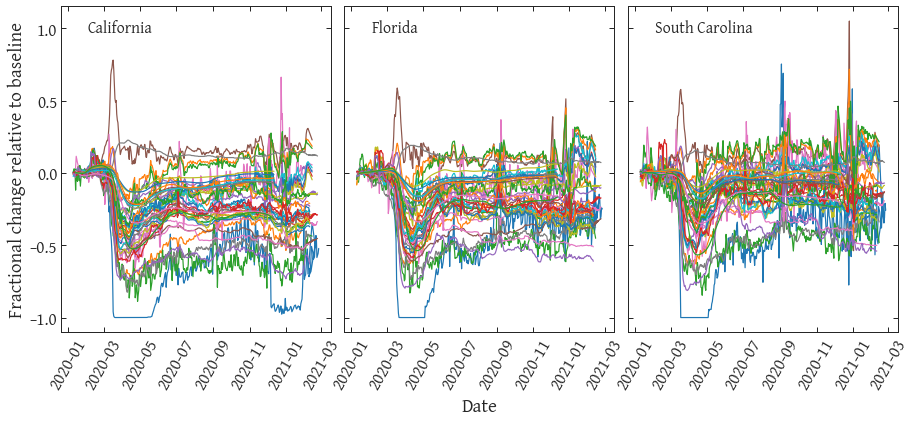

In [143]:
### READY FOR FINAL PLOT @SHERIDAN

master_dat_ot = master_dat.merge(ot_us, on=['statefips', 'Date'], how='left')
print(master_dat_ot['open_table_seatings'].describe())

fields_to_plot = ['open_table_seatings', 'spend_acf', 'spend_aer', 'spend_all', 
                  'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws', 'spend_all_inchigh', 
                  'spend_all_inclow', 'spend_all_incmiddle', 'spend_retail_w_grocery',
                  'spend_retail_no_grocery', 'gps_retail_and_recreation',
                  'gps_grocery_and_pharmacy', 'gps_transit_stations',
                  'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'merchants_all', 'merchants_inchigh',
                  'merchants_inclow', 'merchants_incmiddle', 'merchants_ss40',
                  'merchants_ss60', 'merchants_ss65', 'merchants_ss70', 'revenue_all',
                  'revenue_inchigh', 'revenue_inclow', 'revenue_incmiddle',
                  'revenue_ss40', 'revenue_ss60', 'revenue_ss65', 'revenue_ss70', 'emp_combined',
                  'emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh',
                  'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss65',
                  'emp_combined_ss70']
master_dat_ot.loc[:,fields_to_plot] = master_dat_ot.loc[:,fields_to_plot].replace('.', np.nan)
master_dat_ot.loc[:,fields_to_plot] = master_dat_ot.loc[:,fields_to_plot].astype(float)

fig, ax = plt.subplots(1, 3, figsize=(15,6), sharex=True, sharey=True, gridspec_kw={'wspace':0.05})
for i in range(0,3):
        ax[i].yaxis.set_ticks_position('both')
        ax[i].xaxis.set_ticks_position('both')
        ax[i].tick_params(axis='both', which='minor', colors='black', width=1.0, length=3.0)
        if(i==1):
            ax[i].set_xlabel(r'Date')
        if(i==0):
            ax[i].set_ylabel(r'Fractional change relative to baseline')

#plt.figure(figsize=(8,8))
ax[0].plot(master_dat_ot.loc[master_dat_ot['statefips']==6,'Date'], master_dat_ot.loc[master_dat_ot['statefips']==6, fields_to_plot])
for tick in ax[0].get_xticklabels():
    tick.set_rotation(60)
ax[0].text(0.1, 0.92, 'California', transform=ax[0].transAxes, fontsize=16)
#plt.legend(fields_to_plot)

#plt.figure(figsize=(8,8))
ax[1].plot(master_dat_ot.loc[master_dat_ot['statefips']==12,'Date'], master_dat_ot.loc[master_dat_ot['statefips']==12, fields_to_plot])
for tick in ax[1].get_xticklabels():
    tick.set_rotation(60)
ax[1].text(0.1, 0.92, 'Florida', transform=ax[1].transAxes, fontsize=16)

#plt.figure(figsize=(8,8))
ax[2].plot(master_dat_ot.loc[master_dat_ot['statefips']==45,'Date'], master_dat_ot.loc[master_dat_ot['statefips']==45, fields_to_plot])
for tick in ax[2].get_xticklabels():
    tick.set_rotation(60)
ax[2].text(0.1, 0.92, 'South Carolina', transform=ax[2].transAxes, fontsize=16)

# plt.figure(figsize=(8,8))
# plt.plot(master_dat_ot.loc[master_dat_ot['statefips']==46,'Date'], master_dat_ot.loc[master_dat_ot['statefips']==46, fields_to_plot])
# plt.title('South Dakota')
# for f in fields_to_plot:
#   print(f, (master_dat_ot.loc[master_dat_ot['statefips']==46, f] > 3).sum())
# plt.show()

plt.savefig('../figures/raw_indicators.eps', bbox_inches='tight')

In [40]:
bls_dat = pd.read_csv(dir + 'US_States/Trips_by_Distance.csv')
bls_dat = bls_dat.loc[bls_dat['Level'] == 'State']
bls_dat.loc[:,'statefips'] = bls_dat['State FIPS']
bls_dat['Date'] = pd.to_datetime(bls_dat['Date'])
bls_dat = bls_dat.sort_values(by=['statefips', 'Date']).reset_index()
print(bls_dat.columns)

Index(['index', 'Level', 'Date', 'State FIPS', 'State Postal Code',
       'County FIPS', 'County Name', 'Population Staying at Home',
       'Population Not Staying at Home', 'Number of Trips',
       'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
       'Number of Trips 5-10', 'Number of Trips 10-25',
       'Number of Trips 25-50', 'Number of Trips 50-100',
       'Number of Trips 100-250', 'Number of Trips 250-500',
       'Number of Trips >=500', 'Row ID', 'statefips'],
      dtype='object')


<AxesSubplot:xlabel='Date'>

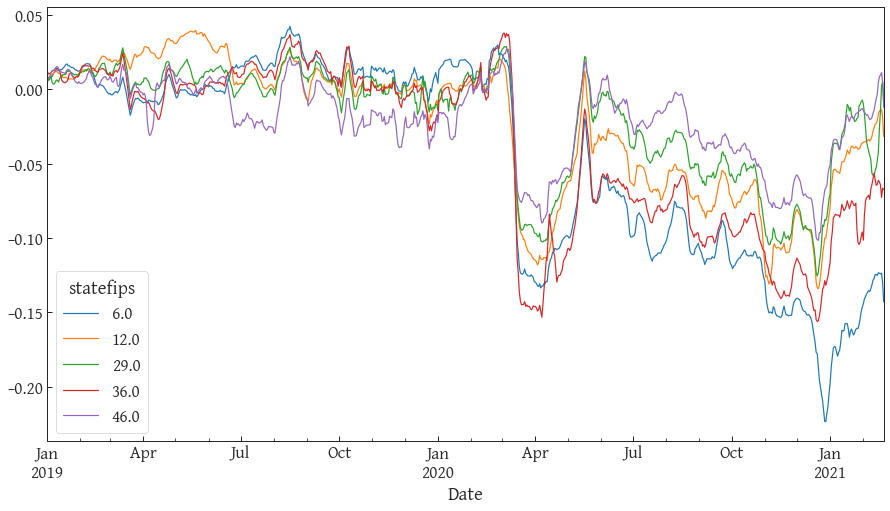

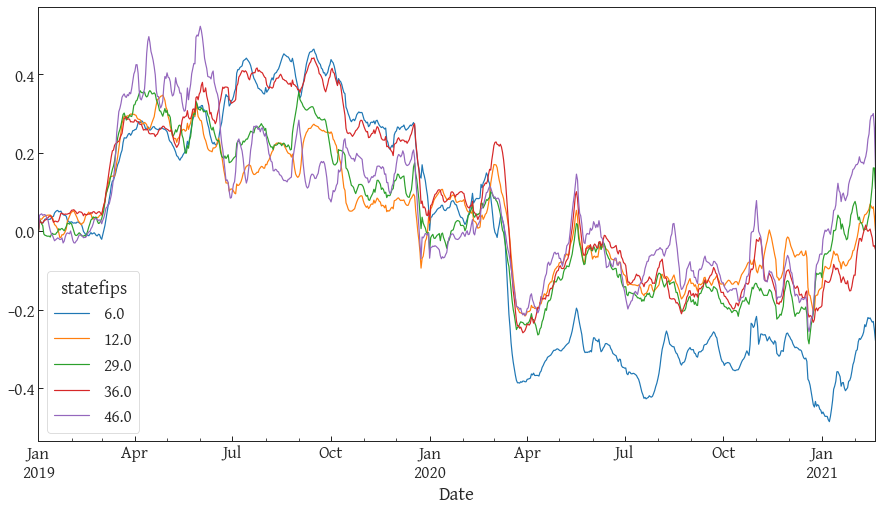

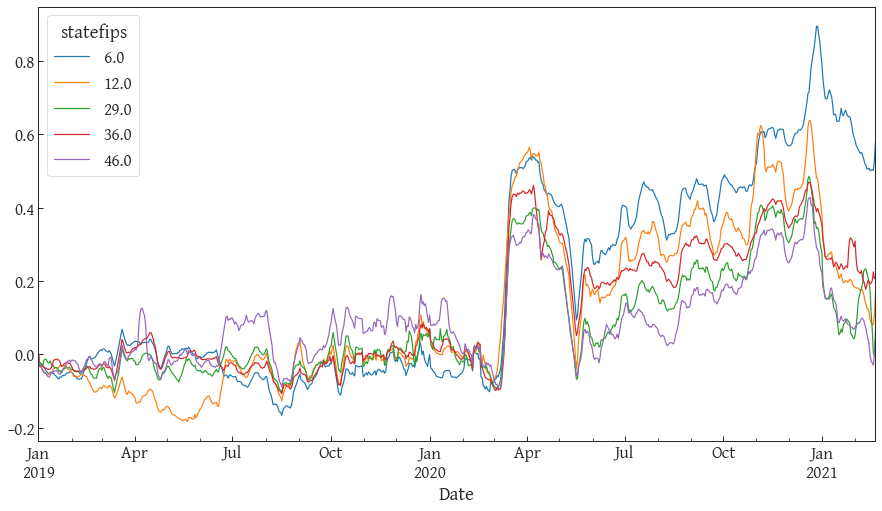

In [41]:
mobility_vars = ['Population Staying at Home', 
                 'Population Not Staying at Home', 'Number of Trips',
                 'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
                 'Number of Trips 5-10', 'Number of Trips 10-25',
                 'Number of Trips 25-50', 'Number of Trips 50-100',
                 'Number of Trips 100-250', 'Number of Trips 250-500',
                 'Number of Trips >=500']

def rolling_forward_mean(dat, var_name, groupby, periods):
  ser = dat[[groupby, var_name]].copy()
  cols = []
  for i in range(periods):
    ser[var_name + '_lag_' + str(i)] = ser.groupby(groupby)[var_name].shift(-i)
    cols = cols + [var_name + '_lag_' + str(i)]
  return ser[cols].mean(axis=1)

for m in mobility_vars:
  bls_dat[m+'_weekroll'] = rolling_forward_mean(bls_dat, m, 'statefips', 7)
  bls_dat[m+'_weekrollfirst'] = bls_dat.groupby('statefips')[m+'_weekroll'].transform('first')
  bls_dat[m+'_weekrollnorm'] = bls_dat[m+'_weekroll'] / bls_dat[m+'_weekrollfirst'] - 1

state_subset = [6, 12, 29, 36, 46]
plt.figure(figsize=(15,8))
bls_dat.loc[bls_dat['statefips'].isin(state_subset)].groupby(['Date', 'statefips'])['Population Not Staying at Home_weekrollnorm'].mean().unstack().plot(ax=plt.gca())

plt.figure(figsize=(15,8))
bls_dat.loc[bls_dat['statefips'].isin(state_subset)].groupby(['Date', 'statefips'])['Number of Trips_weekrollnorm'].mean().unstack().plot(ax=plt.gca())

plt.figure(figsize=(15,8))
bls_dat.loc[bls_dat['statefips'].isin(state_subset)].groupby(['Date', 'statefips'])['Population Staying at Home_weekrollnorm'].mean().unstack().plot(ax=plt.gca())

In [42]:
# Merging BTS data into master
# master_dat = master_dat.merge(bls_dat_trim, on=['statefips', 'Date'], how='left')
# fields_to_plot = ['open_table_seatings', 'spend_acf', 'spend_aer', 'spend_all', 
#                   'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws', 'spend_all_inchigh', 
#                   'spend_all_inclow', 'spend_all_incmiddle', 'spend_retail_w_grocery',
#                   'spend_retail_no_grocery', 'gps_retail_and_recreation',
#                   'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
#                   'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'merchants_all', 'merchants_inchigh',
#                   'merchants_inclow', 'merchants_incmiddle', 'merchants_ss40',
#                   'merchants_ss60', 'merchants_ss65', 'merchants_ss70', 'revenue_all',
#                   'revenue_inchigh', 'revenue_inclow', 'revenue_incmiddle',
#                   'revenue_ss40', 'revenue_ss60', 'revenue_ss65', 'revenue_ss70', 'emp_combined',
#                   'emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh',
#                   'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss65',
#                   'emp_combined_ss70']
# bts_dat_fields = [m + '_weekrollnorm' for m in mobility_vars]
# fields_to_plot_full = fields_to_plot + bts_dat_fields
# master_dat.loc[:,fields_to_plot_full] = master_dat.loc[:,fields_to_plot_full].replace('.', np.nan)
# master_dat.loc[:,fields_to_plot_full] = master_dat.loc[:,fields_to_plot_full].astype(float)

# master_dat.to_csv(dir + 'US_States/cleaned_data/master_mobility_clean.csv')

# plt.figure(figsize=(8,8))
# plt.plot(master_dat.loc[master_dat['statefips']==6,'Date'], master_dat.loc[master_dat['statefips']==6, fields_to_plot_full])
# plt.title('California')

# plt.figure(figsize=(8,8))
# plt.plot(master_dat.loc[master_dat['statefips']==12,'Date'], master_dat.loc[master_dat['statefips']==12, fields_to_plot_full])
# plt.title('Florida')
# plt.show()

In [43]:
# Data cleaning before PCA
pca_fields = ['open_table_seatings', 'spend_acf', 'spend_aer', 'spend_all', 
                  'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws', 'spend_all_inchigh', 
                  'spend_all_inclow', 'spend_all_incmiddle', 'spend_retail_w_grocery',
                  'spend_retail_no_grocery', 'gps_retail_and_recreation',
                  'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
                  'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'merchants_all', 'merchants_inchigh',
                  'merchants_inclow', 'merchants_incmiddle', 'merchants_ss40',
                  'merchants_ss60', 'merchants_ss65', 'merchants_ss70', 'revenue_all',
                  'revenue_inchigh', 'revenue_inclow', 'revenue_incmiddle',
                  'revenue_ss40', 'revenue_ss60', 'revenue_ss65', 'revenue_ss70', 'emp_combined',
                  'emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh',
                  'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss65',
                  'emp_combined_ss70']
master_dat_trim = master_dat_ot.loc[(master_dat_ot['Date'] >= '2020/02/01') & (master_dat_ot['Date'] <= '2021/03/01')].reset_index()
data_only = master_dat_trim[['statefips', 'statename', 'Date'] + pca_fields]
# Tells us how many data entries are filled for each variable. Note that there are 19941 total rows.
print(data_only.describe().loc['count'])

# Start by filling data using linear interpolation
data_filled = data_only.groupby('statefips').apply(lambda group: group.interpolate(method='index', limit_direction='both'))
print(data_filled.describe().loc['count'])
print(data_filled['statename'].value_counts().sort_index())
print(data_filled.groupby('statename')[pca_fields].agg(lambda x: x.isnull().sum()))

# One version is to exclude any data that is not complete
dat_completeness = data_filled.describe().loc['count']
complete_only = list(dat_completeness.loc[dat_completeness == dat_completeness.max()].index)
# Excluding gps_parks because it seems to drive a lot of variation
exclude = ['statefips', 'statename', 'Date', 'gps_parks']
complete_only = [c for c in complete_only if c not in exclude]
print(complete_only)

statefips                    19941.0
open_table_seatings          14165.0
spend_acf                    18755.0
spend_aer                    18755.0
spend_all                    18755.0
spend_apg                    18755.0
spend_grf                    18755.0
spend_hcs                    18755.0
spend_tws                    18755.0
spend_all_inchigh            18755.0
spend_all_inclow             18007.0
spend_all_incmiddle          18755.0
spend_retail_w_grocery       18755.0
spend_retail_no_grocery      18755.0
gps_retail_and_recreation    18666.0
gps_grocery_and_pharmacy     18666.0
gps_parks                    18226.0
gps_transit_stations         18513.0
gps_workplaces               18666.0
gps_residential              18666.0
gps_away_from_home           18666.0
merchants_all                19026.0
merchants_inchigh            19026.0
merchants_inclow             19026.0
merchants_incmiddle          19026.0
merchants_ss40               19026.0
merchants_ss60               18680.0
m

[5.24230790e-01 1.64629499e-01 5.08007557e-02 4.86127418e-02
 4.22419122e-02 2.68787891e-02 2.60636538e-02 1.92605994e-02
 1.71762444e-02 1.27583677e-02 1.09940018e-02 9.29766261e-03
 7.54550070e-03 6.53661544e-03 5.43510846e-03 4.82971273e-03
 4.33361269e-03 3.74998822e-03 3.11161758e-03 2.64306958e-03
 2.47519409e-03 1.64983781e-03 1.55193069e-03 1.04219776e-03
 5.90144607e-04 5.52059881e-04 4.25753553e-04 3.20055852e-04
 1.79655081e-04 7.90595289e-05 3.86837095e-06]


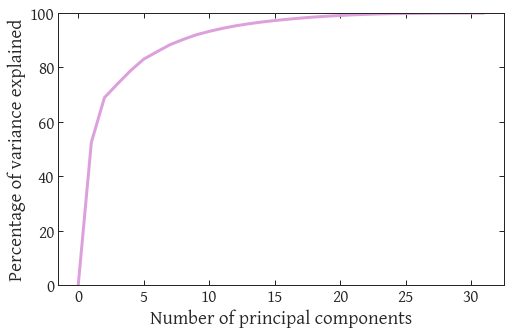

In [61]:
### READY FOR FINAL PLOT @SHERIDAN

fig, ax = plt.subplots(1, figsize=(8,5))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='both', which='minor', colors='black', width=1.0, length=3.0)

pca = PCA()
res = pca.fit(data_filled[complete_only])
print(res.explained_variance_ratio_)
plt.plot(range(len(res.explained_variance_ratio_) + 1), np.insert(res.explained_variance_ratio_.cumsum(), 0, 0)*100., linewidth=3, color='plum')
plt.ylim([0,100])
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of principal components')

principal_components = res.transform(data_filled[complete_only])
n_components = 5
principal_components_dat = pd.DataFrame(principal_components[:,0:n_components], 
                                        columns=['pca_' + str(i) for i in range(n_components)])

plt.savefig('../figures/cumulative_variance.eps')

In [62]:
print(principal_components_dat)
print(master_dat_trim)
final_dat_pca = pd.concat([master_dat_trim, principal_components_dat], axis=1)
print(final_dat_pca)

          pca_0     pca_1     pca_2     pca_3     pca_4
0      1.257103 -0.170916  0.016646  0.329639 -0.032368
1      1.180556 -0.097426 -0.151020  0.205304 -0.270364
2      1.241165 -0.071005 -0.057720  0.352986 -0.114250
3      1.262754  0.030547 -0.016757  0.379672 -0.078638
4      1.243541 -0.104450 -0.007656  0.366023 -0.102246
...         ...       ...       ...       ...       ...
19936 -0.363557  0.272571  0.061494  0.070347 -0.029618
19937  0.296143  0.112051  0.646212 -0.270918 -0.078228
19938  0.066871  0.310949 -0.081173 -0.073165 -0.195458
19939 -0.120157  0.288586 -0.081735 -0.089380 -0.063826
19940  0.028266 -0.093991 -0.144094  0.048175 -0.032526

[19941 rows x 5 columns]
       index  year  month  day  statefips freq  spend_acf  spend_aer  \
0       1554  2020      2    1          1    d    0.00465   -0.08820   
1       1555  2020      2    1          2    d    0.13400   -0.13500   
2       1556  2020      2    1          4    d    0.01400    0.04230   
3       1557  

In [63]:
pca_0_min = final_dat_pca['pca_0'].min()
pca_0_max = final_dat_pca['pca_0'].max()
max_adj = final_dat_pca.loc[final_dat_pca['Date'] <= '02/15/2020', 'pca_0'].mean()
print(final_dat_pca.loc[final_dat_pca['Date'] <= '02/15/2020', 'pca_0'].describe())
final_dat_pca['shadow_index_raw'] = (pca_0_max - final_dat_pca['pca_0'])/(pca_0_max - pca_0_min) * 100
final_dat_pca['shadow_index_normalized'] = final_dat_pca['pca_0'].apply(lambda x: (max_adj - min(x, max_adj))/(max_adj - pca_0_min) * 100)

count    765.000000
mean       1.358350
std        0.210343
min        0.363822
25%        1.241165
50%        1.329626
75%        1.459333
max        2.559423
Name: pca_0, dtype: float64


In [69]:
final_dat_pca

,index,year,month,day,statefips,freq,spend_acf,spend_aer,spend_all,spend_apg,...,stateabbrev,xwalk,open_table_seatings,pca_0,pca_1,pca_2,pca_3,pca_4,shadow_index_raw,shadow_index_normalized
0,1554,2020,2,1,1,d,0.00465,-0.08820,-0.0267,-0.00349,...,AL,both,NaN,1.257103,-0.170916,0.016646,0.329639,-0.032368,30.301240,3.269364
1,1555,2020,2,1,2,d,0.13400,-0.13500,0.0260,0.04820,...,AK,both,NaN,1.180556,-0.097426,-0.151020,0.205304,-0.270364,32.082285,5.741167
2,1556,2020,2,1,4,d,0.01400,0.04230,0.0118,0.04570,...,AZ,both,NaN,1.241165,-0.071005,-0.057720,0.352986,-0.114250,30.672093,3.784048
3,1557,2020,2,1,5,d,0.00218,0.03200,0.0357,0.09440,...,AR,both,NaN,1.262754,0.030547,-0.016757,0.379672,-0.078638,30.169774,3.086911
4,1558,2020,2,1,6,d,0.00386,0.00641,-0.0051,0.02690,...,CA,both,NaN,1.243541,-0.104450,-0.007656,0.366023,-0.102246,30.616808,3.707321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19936,21502,2021,2,25,51,NaN,NaN,NaN,NaN,NaN,...,VA,both,-0.4380,-0.363557,0.272571,0.061494,0.070347,-0.029618,68.009369,55.602165
19937,21503,2021,2,25,53,NaN,NaN,NaN,NaN,NaN,...,WA,both,-0.6041,0.296143,0.112051,0.646212,-0.270918,-0.078228,52.660031,34.299759
19938,21504,2021,2,25,54,NaN,NaN,NaN,NaN,NaN,...,WV,both,NaN,0.066871,0.310949,-0.081173,-0.073165,-0.195458,57.994545,41.703204
19939,21505,2021,2,25,55,NaN,NaN,NaN,NaN,NaN,...,WI,both,-0.4543,-0.120157,0.288586,-0.081735,-0.089380,-0.063826,62.346136,47.742510


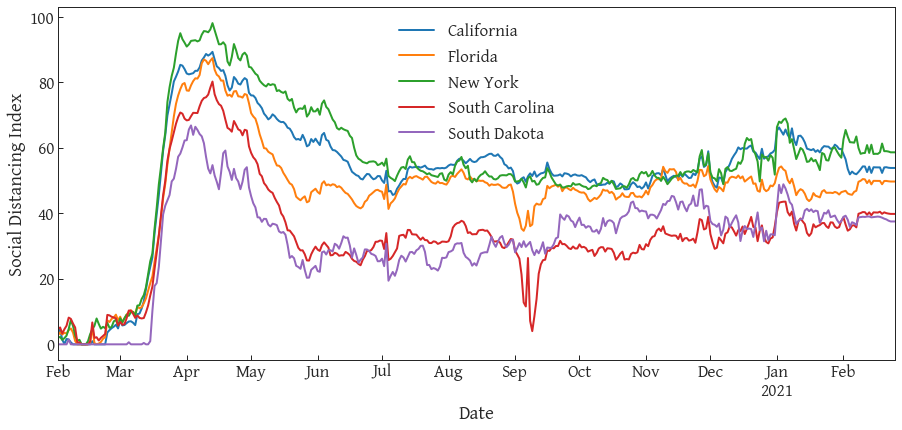

In [82]:
fig, ax = plt.subplots(1, figsize=(15,6.5))
ax.tick_params(axis='x', which='minor', width=0.0)

state_subset = [6, 12, 36, 45, 46]
final_dat_pca.loc[final_dat_pca['statefips'].isin(state_subset)].groupby(['Date', 'statename'])['shadow_index_normalized'].mean().unstack().plot(ax=plt.gca(), linewidth=2)
ax.legend(frameon=False)
ax.set_ylabel(r'Social Distancing Index')
plt.savefig('../figures/sdi_5states.eps', bbox_inches='tight')

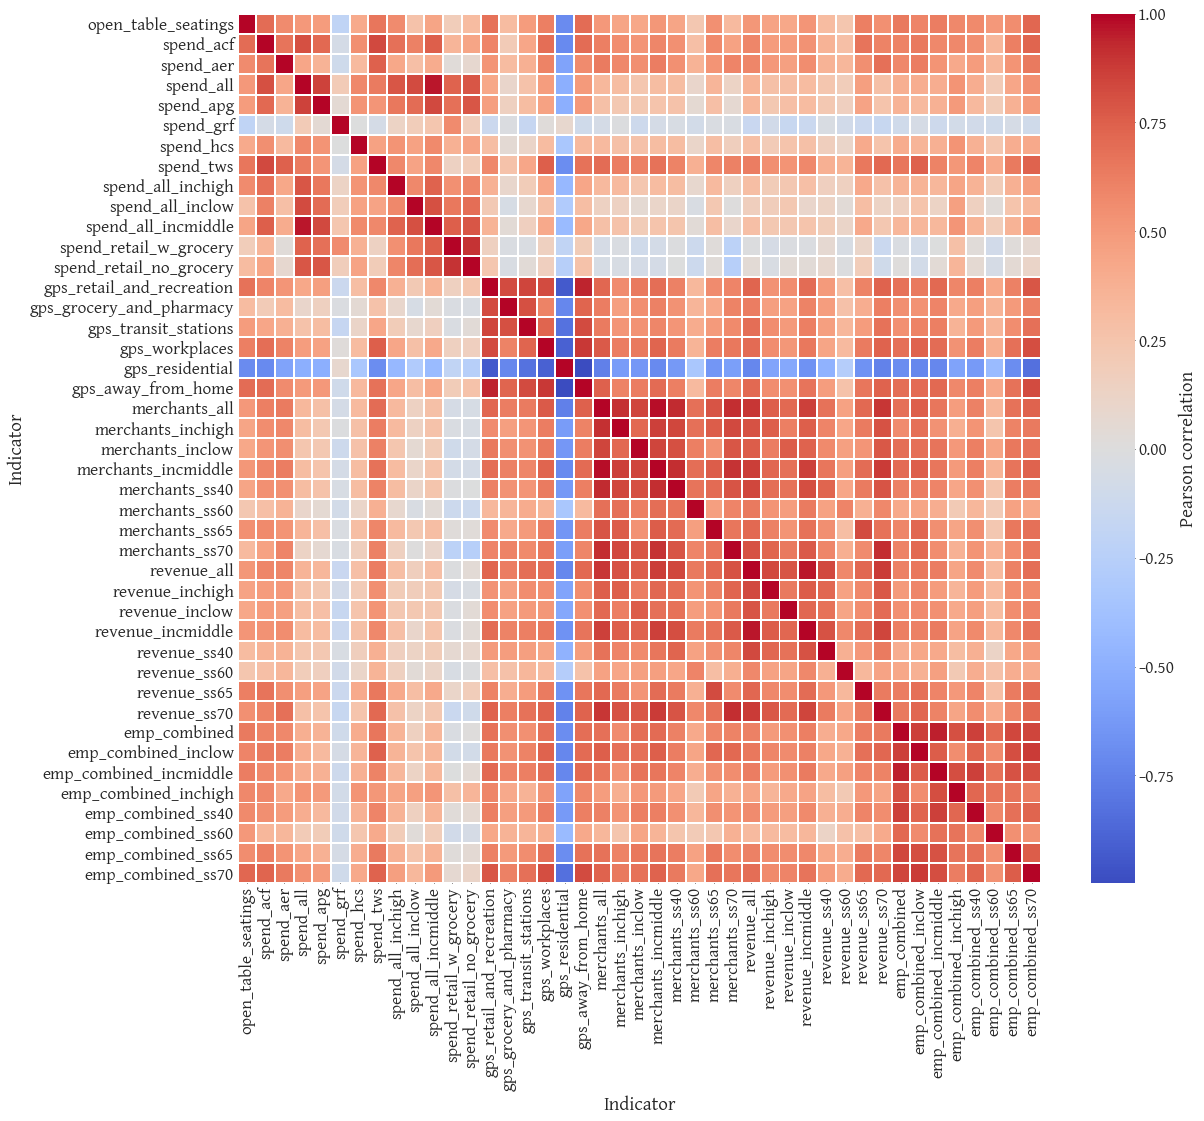

In [132]:
plt.figure(figsize=(18,16))
ax = sns.heatmap(final_dat_pca[fields_to_plot].corr(), cmap='coolwarm', 
            linewidth=1, linecolor='white', cbar_kws={'label': r'Pearson correlation'})
ax.set_xlabel(r'Indicator')
ax.set_ylabel(r'Indicator')
plt.savefig('../figures/corr_raw_indicators.eps', bbox_inches='tight')

# Reference https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md

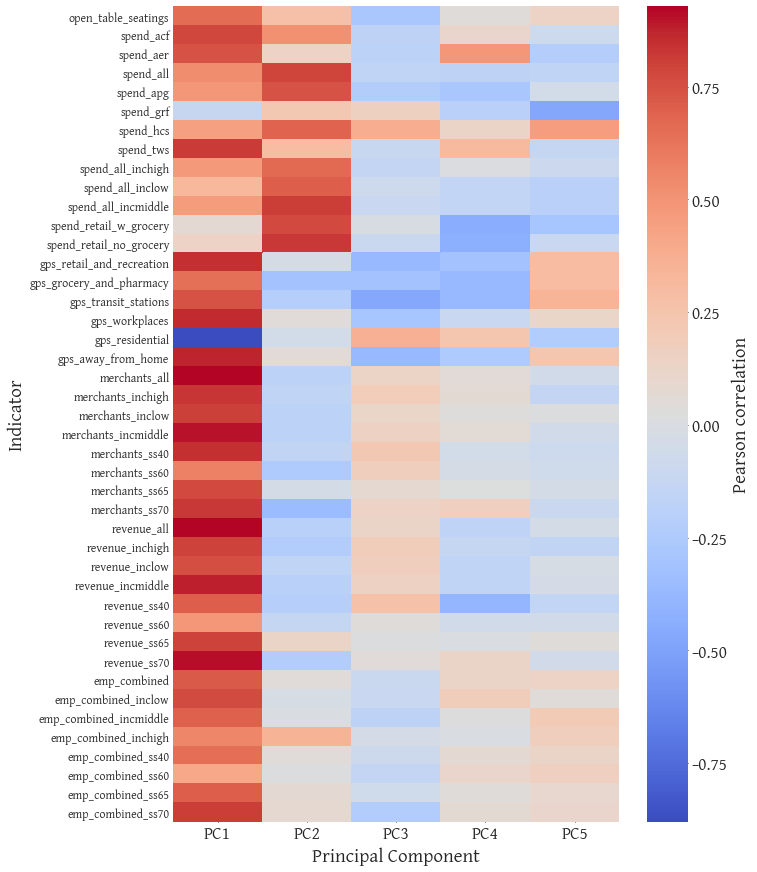

In [134]:
plt.figure(figsize=(10,15))
ax = sns.heatmap(final_dat_pca.corr()[['pca_0','pca_1', 'pca_2', 'pca_3', 'pca_4']].loc[fields_to_plot], cmap='coolwarm', 
            cbar_kws={'label': r'Pearson correlation'})
ax.set_ylabel(r'Indicator')
ax.set_xlabel(r'Principal Component')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

ax.set_xticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

plt.savefig('../figures/corr_indicators_pca.eps', bbox_inches='tight')

['index', 'year', 'month', 'day', 'statefips', 'freq', 'spend_acf', 'spend_aer', 'spend_all', 'spend_apg', 'spend_grf', 'spend_hcs', 'spend_tws', 'spend_all_inchigh', 'spend_all_inclow', 'spend_all_incmiddle', 'spend_retail_w_grocery', 'spend_retail_no_grocery', 'provisional', 'Date', 'day_endofweek_x', 'bg_posts', 'bg_posts_ss30', 'bg_posts_ss55', 'bg_posts_ss60', 'bg_posts_ss65', 'bg_posts_ss70', 'bg_posts_jz1', 'bg_posts_jzgrp12', 'bg_posts_jz2', 'bg_posts_jz3', 'bg_posts_jzgrp345', 'bg_posts_jz4', 'bg_posts_jz5', 'case_count', 'death_count', 'test_count', 'case_rate', 'death_rate', 'test_rate', 'new_case_rate', 'new_death_rate', 'new_test_rate', 'new_case_count', 'new_death_count', 'new_test_count', 'emp_combined', 'emp_combined_inclow', 'emp_combined_incmiddle', 'emp_combined_inchigh', 'emp_combined_ss40', 'emp_combined_ss60', 'emp_combined_ss65', 'emp_combined_ss70', 'gps_retail_and_recreation', 'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations', 'gps_workplaces', 'g

<AxesSubplot:>

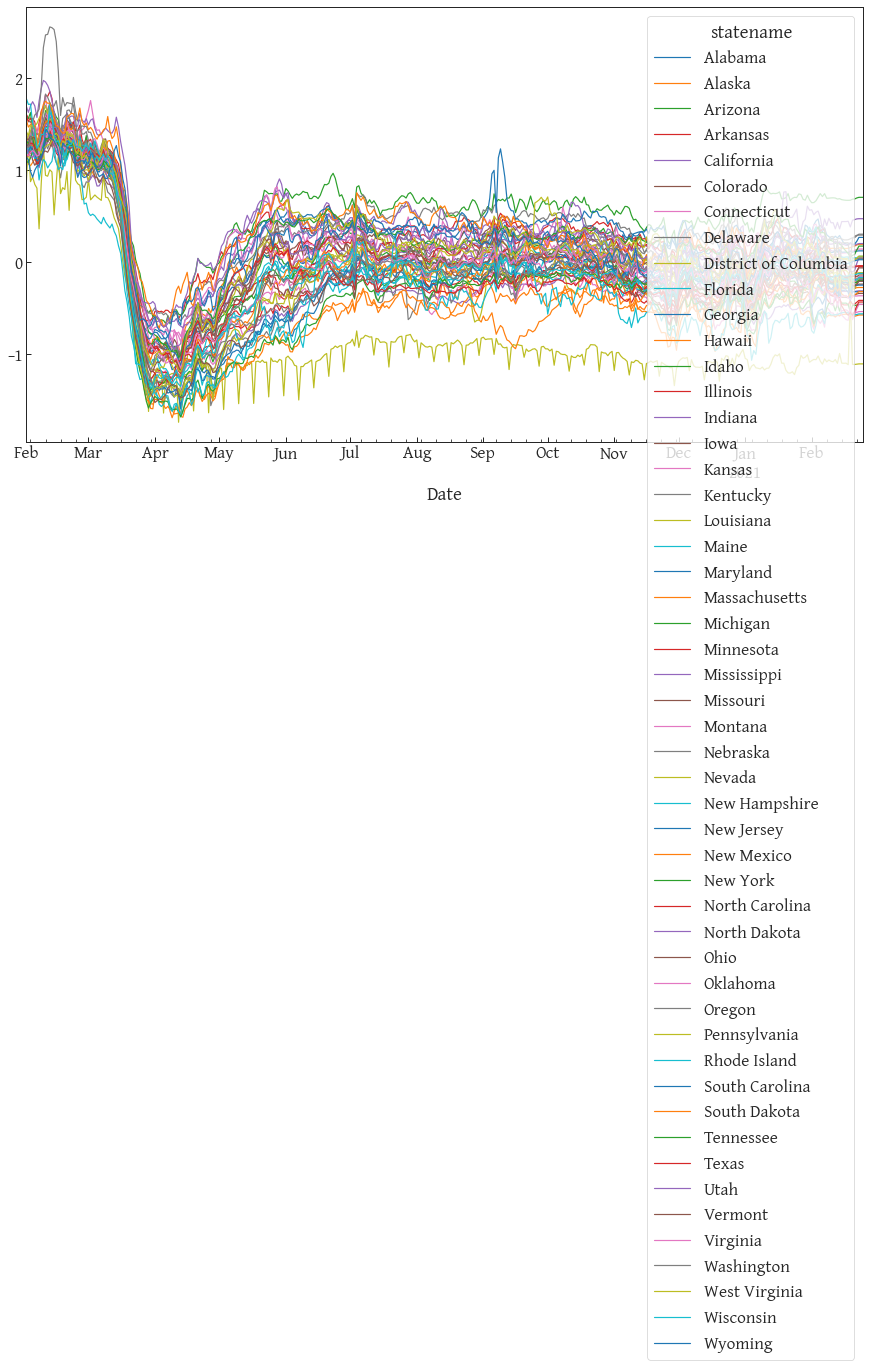

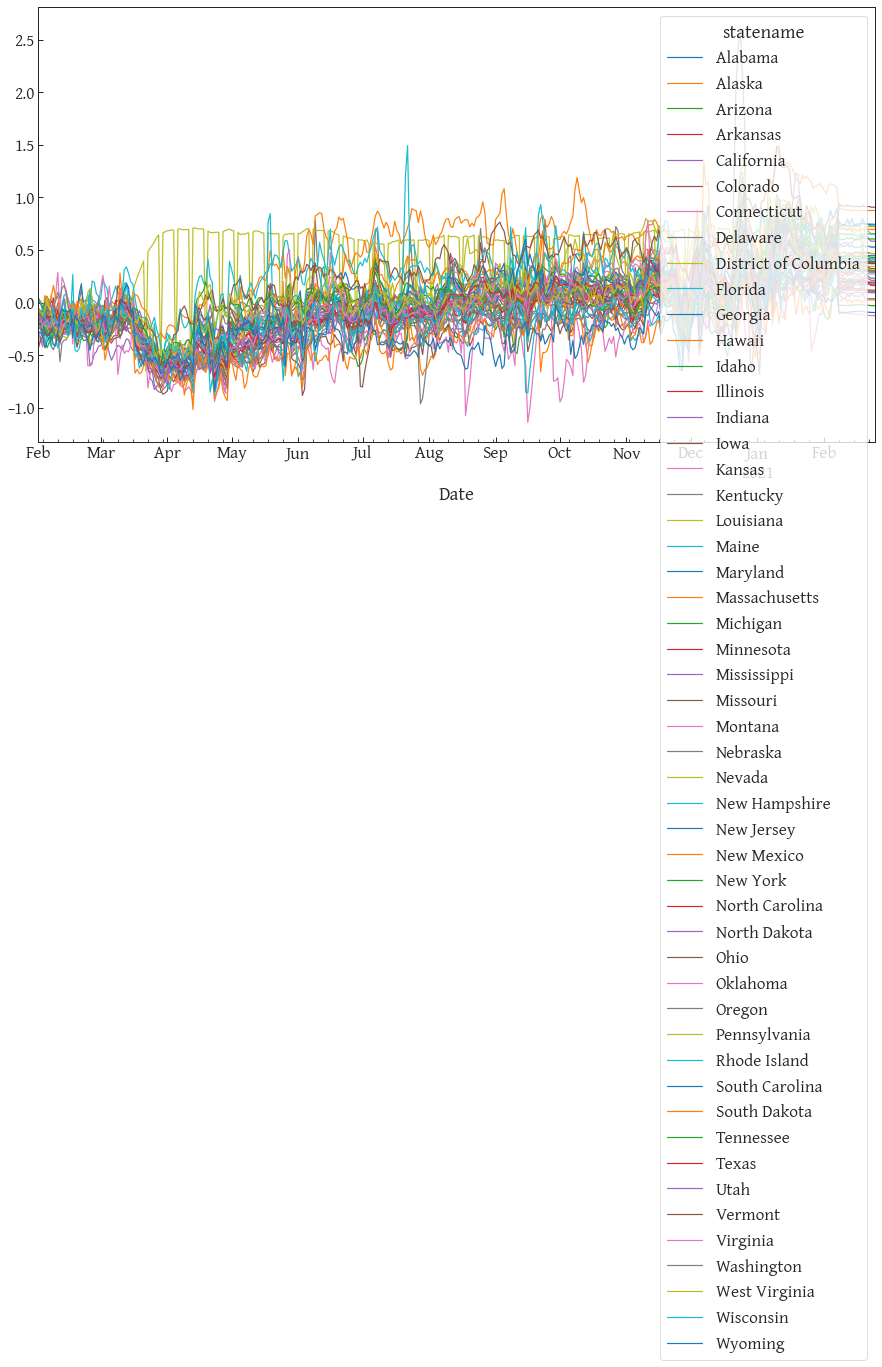

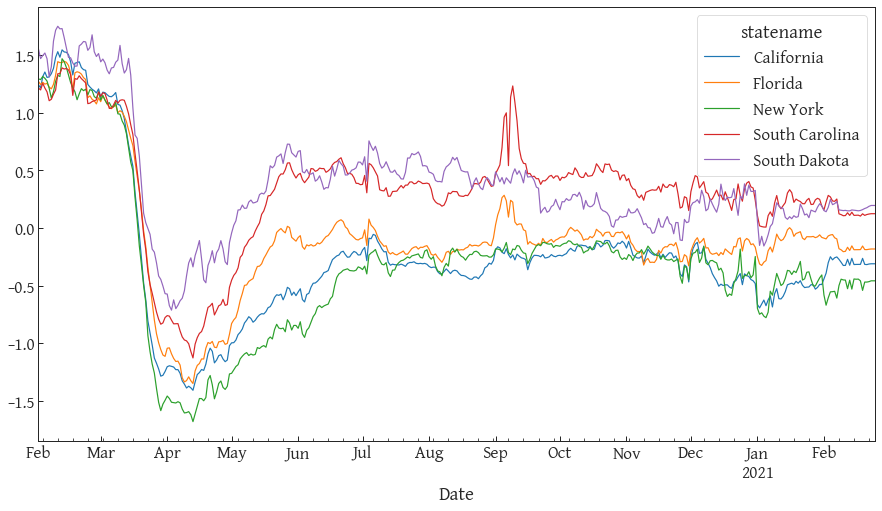

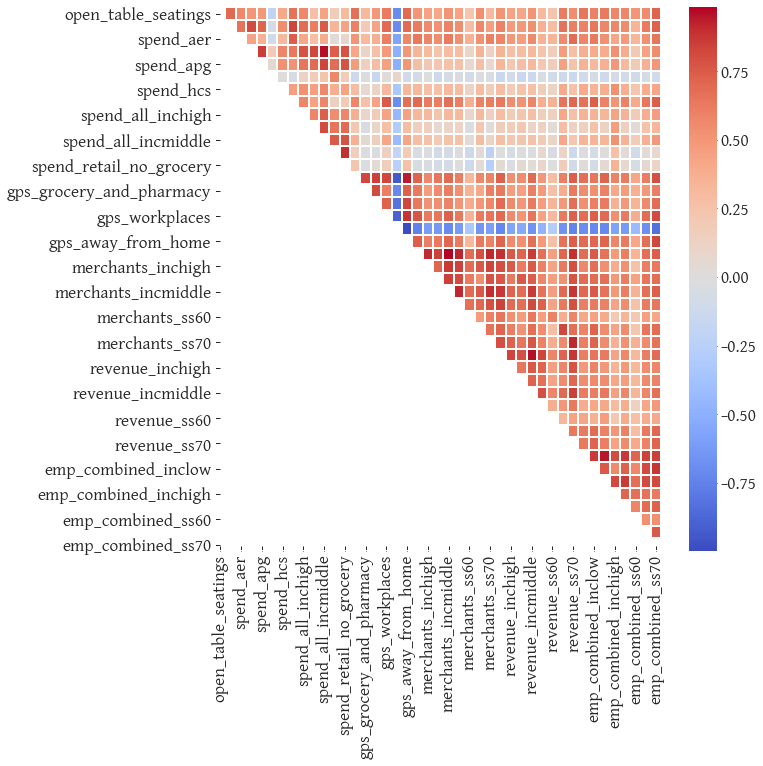

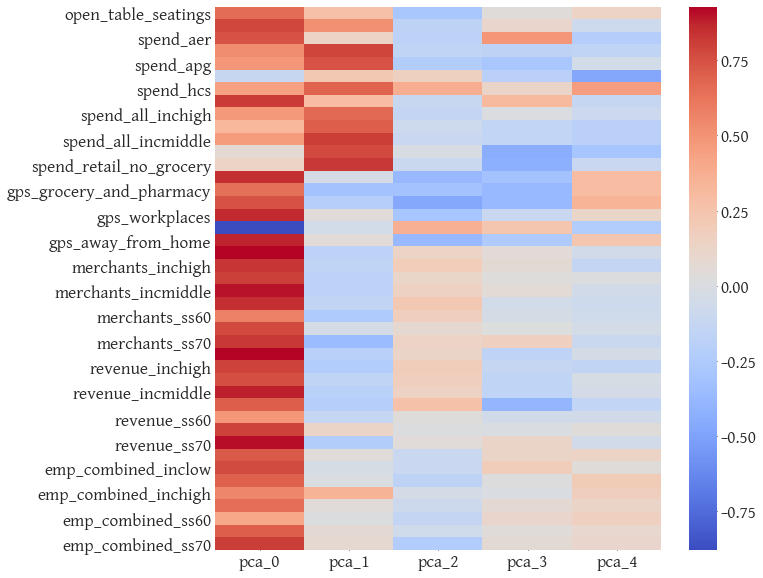

In [64]:
### READY FOR FINAL PLOT @SHERIDAN

print(list(final_dat_pca.columns))
plt.figure(figsize=(15,8))
final_dat_pca.groupby(['Date', 'statename'])['pca_0'].mean().unstack().plot(ax=plt.gca())
plt.figure(figsize=(15,8))
final_dat_pca.groupby(['Date', 'statename'])['pca_1'].mean().unstack().plot(ax=plt.gca())

print(final_dat_pca.corr()['pca_0'][fields_to_plot])
print(final_dat_pca.corr()['pca_1'][fields_to_plot])
plt.figure(figsize=(10,10))
sns.heatmap(final_dat_pca[fields_to_plot].corr(), cmap='coolwarm', mask=np.tril(np.ones((len(fields_to_plot), len(fields_to_plot)))).astype(np.bool), 
            linewidth=1, linecolor='white')
plt.figure(figsize=(10,10))
sns.heatmap(final_dat_pca.corr()[['pca_0','pca_1', 'pca_2', 'pca_3', 'pca_4']].loc[fields_to_plot], cmap='coolwarm')

In [128]:
final_dat_pca['strdate'] = final_dat_pca['Date'].astype(str)

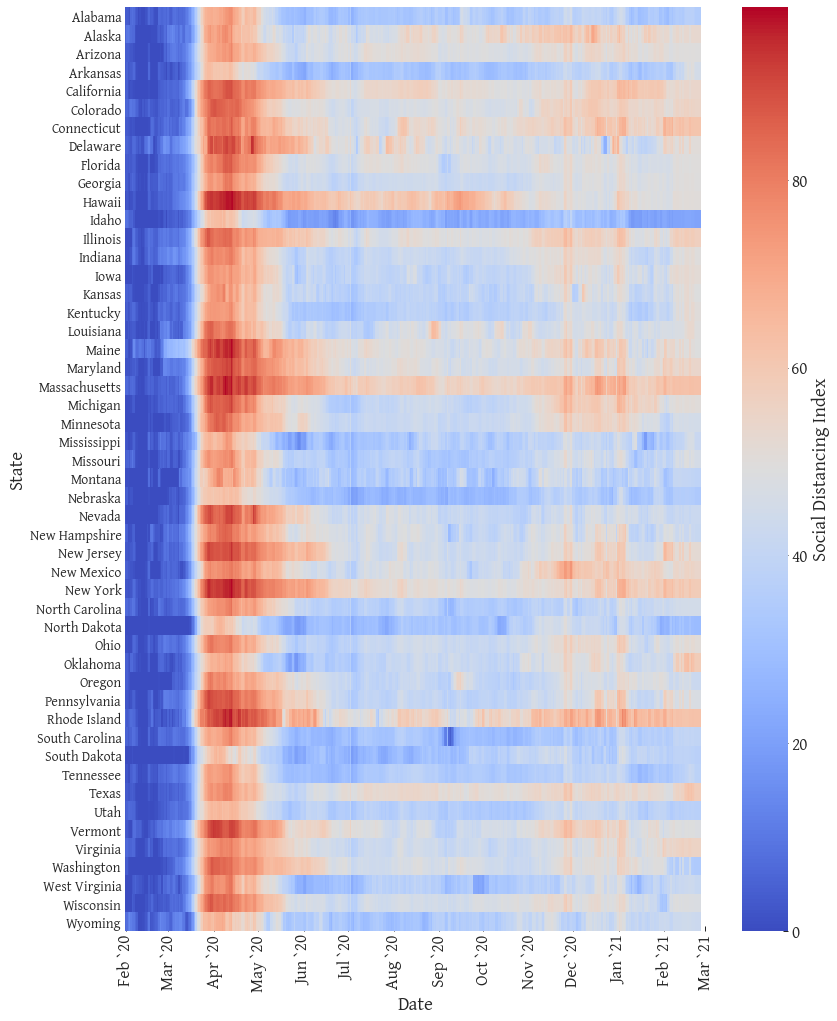

In [145]:
### READY FOR FINAL PLOT @SHERIDAN

fig,ax = plt.subplots(figsize=(13, 17))
sns.heatmap(final_dat_pca.loc[final_dat_pca['statename'] != 'District of Columbia'].groupby(['statename', 'strdate'])['shadow_index_normalized'].mean().unstack(), 
            cmap='coolwarm', ax=ax, cbar_kws={'label': r'Social Distancing Index'})

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

ax.set_ylabel('State')
ax.set_xlabel('Date')

set_date_ticks(ax, '2020-02-01', '2021-03-01', freq='1MS', axis='x', date_format='%b `%y')

plt.savefig('../figures/sdi_by_state.eps', bbox_inches='tight')

In [ ]:
final_dat_pca.to_csv(dir + 'US_States/cleaned_data/mobility_pca_data_clean.csv')
final_dat_pca[['statefips', 'statename', 'Date', 'shadow_index_normalized']].to_csv(dir + 'US_States/cleaned_data/mobility_pca_only.csv')